<a href="https://colab.research.google.com/github/aden-innis/storywall-week-5/blob/main/Storywall_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy
from tensorflow.keras.models import Sequential

from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from pathlib import Path

if not Path("NHTSA_NMVCCS_extract.parquet.gzip").exists():
    print("Downloading dataset")
    !wget https://github.com/JSchelldorfer/ActuarialDataScience/raw/master/12%20-%20NLP%20Using%20Transformers/NHTSA_NMVCCS_extract.parquet.gzip

df = pd.read_parquet("NHTSA_NMVCCS_extract.parquet.gzip")
print(f"shape of DataFrame: {df.shape}")

shape of DataFrame: (6949, 16)


In [ ]:
df["SUMMARY_EN"]

0       V1, a 2000 Pontiac Montana minivan, made a lef...
1       The crash occurred in the eastbound lane of a ...
2       This crash occurred just after the noon time h...
3       This single vehicle crash occurred just before...
4       The crash occurred on a two lane undivided lev...
                              ...                        
6944    The crash occurred at a three-way intersection...
6945    The crash occurred in the northbound lanes of ...
6946    The crash occurred in the eastbound lanes of a...
6947    This single-vehicle crash occurred in a rural ...
6948    This two vehicle daytime collision occurred mi...
Name: SUMMARY_EN, Length: 6949, dtype: object

In [ ]:
# Replace every \r with \n
def replace_carriage_return(summary):
    return summary.replace("\r", "\n")

df["SUMMARY_EN"] = df["SUMMARY_EN"].map(replace_carriage_return)
print(df["SUMMARY_EN"].iloc[1][:500])

The crash occurred in the eastbound lane of a two-lane, two-way asphalt roadway on level grade.  The conditions were daylight and wet with cloudy skies in the early afternoon on a weekday.	
 
 V1, a 1995 Chevrolet Lumina was traveling eastbound.  V2, a 2004 Chevrolet Trailblazer was also traveling eastbound on the same roadway.  V2, was attempting to make a left-hand turn into a private drive on the North side of the roadway.  While turning V1 attempted to pass V2 on the left-hand side contactin


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6949 entries, 0 to 6948
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   level_0     6949 non-null   int64 
 1   index       6949 non-null   int64 
 2   SCASEID     6949 non-null   int64 
 3   SUMMARY_EN  6949 non-null   object
 4   SUMMARY_GE  6949 non-null   object
 5   INJSEVA     6949 non-null   int64 
 6   NUMTOTV     6949 non-null   int64 
 7   WEATHER1    6949 non-null   int64 
 8   WEATHER2    6949 non-null   int64 
 9   WEATHER3    6949 non-null   int64 
 10  WEATHER4    6949 non-null   int64 
 11  WEATHER5    6949 non-null   int64 
 12  WEATHER6    6949 non-null   int64 
 13  WEATHER7    6949 non-null   int64 
 14  WEATHER8    6949 non-null   int64 
 15  INJSEVB     6949 non-null   int64 
dtypes: int64(14), object(2)
memory usage: 868.8+ KB


In [ ]:
df['INJSEVB'].value_counts()

0    3935
1    3014
Name: INJSEVB, dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder
target_labels = df["INJSEVB"]
target = LabelEncoder().fit_transform(target_labels)
target

array([1, 0, 0, ..., 0, 0, 0])

In [ ]:
weather_cols = [f"WEATHER{i}" for i in range(1, 9)]
features = df[["SUMMARY_EN"] + weather_cols]

X_main, X_test, y_main, y_test = \
    train_test_split(features, target, test_size=0.2, random_state=1)

# As 0.25 x 0.8 = 0.2
X_train, X_val, y_train, y_val = \
    train_test_split(X_main, y_main, test_size=0.25, random_state=1)

X_train.shape, X_val.shape, X_test.shape

((4169, 9), (1390, 9), (1390, 9))

In [ ]:
print([np.mean(y_train == y) for y in [0, 1]])

[0.5739985608059487, 0.4260014391940513]


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(ngram_range=(1,3), max_features=1000, stop_words="english")
vect.fit(X_train["SUMMARY_EN"])
vocab = list(vect.get_feature_names_out())
len(vocab)

1000

In [ ]:
def vectorise_dataset(X, vect, txt_col="SUMMARY_EN", dataframe=False):
    X_vects = vect.transform(X[txt_col]).toarray()
    X_other = X.drop(txt_col, axis=1)

    if not dataframe:
        return np.concatenate([X_vects, X_other], axis=1)
    else:
        # Add column names and indices to the combined dataframe.
        vocab = list(vect.get_feature_names_out())
        X_vects_df = pd.DataFrame(X_vects, columns=vocab, index=X.index)
        return pd.concat([X_vects_df, X_other], axis=1)

In [ ]:
X_train_ct = vectorise_dataset(X_train, vect)
X_val_ct = vectorise_dataset(X_val, vect)
X_test_ct = vectorise_dataset(X_test, vect)

In [ ]:
num_features = X_train_ct.shape[1]
num_cats = 2 # 1, 2 vehicles

def build_model(num_features, num_cats):
    random.seed(42)

    model = Sequential([
        Dense(100, input_dim=num_features, activation="relu"),
        Dense(num_cats, activation="softmax")
    ])


    model.compile("adam", "SparseCategoricalCrossentropy",
        metrics=["accuracy"])

    return model

In [ ]:
model1 = build_model(num_features, num_cats)
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               100900    
                                                                 
 dense_3 (Dense)             (None, 2)                 202       
                                                                 
Total params: 101,102
Trainable params: 101,102
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es = EarlyStopping(patience=1, restore_best_weights=True,
    monitor="val_accuracy", verbose=2)
%time hist = model1.fit(X_train_ct, y_train, epochs=10, \
    callbacks=[es], validation_data=(X_val_ct, y_val), verbose=0);

Restoring model weights from the end of the best epoch: 2.
Epoch 3: early stopping
CPU times: user 2.41 s, sys: 157 ms, total: 2.57 s
Wall time: 2.21 s


In [ ]:
model1.evaluate(X_val_ct, y_val, verbose=0)

[7.025191307067871, 0.8827338218688965]

In [ ]:
model1.evaluate(X_val_ct, y_val, verbose=0)

[7.025191307067871, 0.8827338218688965]

In [ ]:
accuracy1 = model1.evaluate(X_test_ct, y_test, verbose=0)[1]

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")
def lemmatize(txt):
    doc = nlp(txt)
    good_tokens = [token.lemma_.lower() for token in doc \
        if not token.like_num and \
           not token.is_punct and \
           not token.is_space and \
           not token.is_currency and \
           not token.is_stop]
    return " ".join(good_tokens)

In [ ]:
df["SUMMARY_EN_LEMMA"] = df["SUMMARY_EN"].map(lemmatize)

In [ ]:
weather_cols = [f"WEATHER{i}" for i in range(1, 9)]
features = df[["SUMMARY_EN_LEMMA"] + weather_cols]

X_main_2, X_test_2, y_main_2, y_test_2 = \
    train_test_split(features, target, test_size=0.2, random_state=1)

# As 0.25 x 0.8 = 0.2
X_train_2, X_val_2, y_train_2, y_val_2 = \
    train_test_split(X_main_2, y_main_2, test_size=0.25, random_state=1)

X_train_2.shape, X_val_2.shape, X_test_2.shape

((4169, 9), (1390, 9), (1390, 9))

In [ ]:
vect = CountVectorizer(max_features=1_000, stop_words="english")
vect.fit(X_train_2["SUMMARY_EN_LEMMA"])
vocab = vect.get_feature_names_out()
len(vocab)

1000

In [ ]:
X_train_ct_2 = vectorise_dataset(X_train_2, vect, "SUMMARY_EN_LEMMA")
X_val_ct_2 = vectorise_dataset(X_val_2, vect, "SUMMARY_EN_LEMMA")
X_test_ct_2 = vectorise_dataset(X_test_2, vect, "SUMMARY_EN_LEMMA")

In [ ]:
num_features = X_train_ct_2.shape[1]
model2 = build_model(num_features, num_cats)
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               100900    
                                                                 
 dense_5 (Dense)             (None, 2)                 202       
                                                                 
Total params: 101,102
Trainable params: 101,102
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es = EarlyStopping(patience=1, restore_best_weights=True,
    monitor="val_accuracy", verbose=2)
%time hist = model2.fit(X_train_ct_2, y_train_2, epochs=10, \
    callbacks=[es], validation_data=(X_val_ct_2, y_val_2), verbose=0);

Restoring model weights from the end of the best epoch: 1.
Epoch 2: early stopping
CPU times: user 2.05 s, sys: 113 ms, total: 2.16 s
Wall time: 2.06 s


In [ ]:
model2.evaluate(X_train_ct_2, y_train_2, verbose=0)

[0.24901746213436127, 0.9186855554580688]

In [ ]:
accuracy2 = model2.evaluate(X_val_ct_2, y_val_2, verbose=0)[1]

In [ ]:
def permutation_test(model, X, y, num_reps=1, seed=42):
    """
    Run the permutation test for variable importance.
    Returns matrix of shape (X.shape[1], len(model.evaluate(X, y))).
    """
    rnd.seed(seed)
    scores = []

    for j in range(X.shape[1]):
        original_column = np.copy(X[:, j])
        col_scores = []

        for r in range(num_reps):
            rnd.shuffle(X[:,j])
            col_scores.append(model.evaluate(X, y, verbose=0))

        scores.append(np.mean(col_scores, axis=0))
        X[:,j] = original_column

    return np.array(scores)

In [ ]:
print(accuracy1)
print(accuracy2)

0.8892086148262024
0.8647481799125671


In [ ]:
if accuracy1 > accuracy2:
  best_model = model1
  vect = CountVectorizer(ngram_range=(1,3), max_features=1000, stop_words="english")
  vect.fit(X_train["SUMMARY_EN"])
  vocab = list(vect.get_feature_names_out())
  len(vocab)
else:
  best_model = model2
  X_val_ct = X_val_ct_2

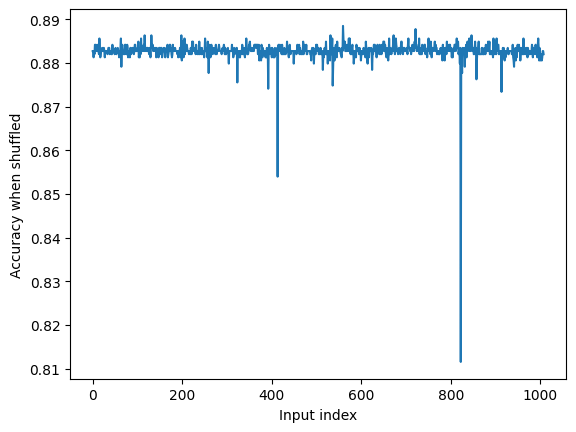

In [ ]:
perm_scores = permutation_test(best_model, X_val_ct, y_val)[:,1]
plt.plot(perm_scores);
plt.xlabel("Input index"); plt.ylabel("Accuracy when shuffled");

In [ ]:

vocab = vect.get_feature_names_out()
input_cols = list(vocab) + weather_cols

best_input_inds = np.argsort(perm_scores)[:5]
best_inputs = [input_cols[idx] for idx in best_input_inds]

print(best_inputs)

['transported', 'injuries', 'v2', 'hospital', 'minor']
